In [401]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Loading

In [409]:
raw_hmda = pd.read_csv('data/hmda_lar__smith_county__all_years.csv', dtype={
    'census_tract_number': 'str'
}, na_values=[
    'Not applicable',
    'Information not provided by applicant in mail, Internet, or telephone application'
])

tract_geos = gpd.read_file('data/tl_2017_48_tract')

raw_census = pd.read_csv('data/ACS_16_5YR_B03002/ACS_16_5YR_B03002.csv', dtype={
    'GEO.id2': 'str'
})

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Enrichment

In [407]:
enriched_hmda = raw_hmda.copy(deep=True)

enriched_hmda['log_loan_amount_000s'] = np.log(enriched_hmda['loan_amount_000s'])
enriched_hmda['log_applicant_income_000s'] = np.log(enriched_hmda['applicant_income_000s'])

def race_ethnicity(row):
    if row['applicant_ethnicity_name'] == 'Hispanic or Latino':
        return 'Latino'
    elif row['applicant_ethnicity_name'] == 'Not Hispanic or Latino':
        if row['applicant_race_name_1'] == 'White':
            return 'White'
        elif row['applicant_race_name_1'] == 'Black or African American':
            return 'Black'
        elif row['applicant_race_name_1'] == 'Asian':
            return 'Asian'
        elif row['applicant_race_name_1'] == 'American Indian or Alaska Native':
            return 'Native American'
        elif row['applicant_race_name_1'] == 'Native Hawaiian or Other Pacific Islander':
            return 'Native Hawaiian'
        else:
            return np.nan
    
    return np.nan
    
def census_tract_number_string(row):
    if str(row['census_tract_number']) == 'nan':
        return None
    
    return str(row['census_tract_number']).replace('.', '').rjust(6, '0')

enriched_hmda['race_ethnicity'] = enriched_hmda.apply(race_ethnicity, axis=1)
enriched_hmda['census_tract_number_string'] = enriched_hmda.apply(census_tract_number_string, axis=1)

In [415]:
enriched_census = raw_census.copy(deep=True)

enriched_census['census_tract_number_string'] = enriched_census['GEO.id2'].str.slice(-6)

enriched_census['percent_black'] = enriched_census['HD01_VD04'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_latino'] = enriched_census['HD01_VD12'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_asian'] = enriched_census['HD01_VD06'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_native_american'] = enriched_census['HD01_VD05'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_native_hawaiian'] = enriched_census['HD01_VD07'] / enriched_census['HD01_VD01'] * 100

# Filtering

In [372]:
filtered_hmda = enriched_hmda.copy(deep=True)

filtered_hmda = filtered_hmda[
    (filtered_hmda['loan_type_name'] == 'Conventional') &
    (filtered_hmda['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (filtered_hmda['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (filtered_hmda['loan_purpose_name'] == 'Home purchase') &
    (filtered_hmda['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (filtered_hmda['loan_amount_000s'] < 90000) &
    (filtered_hmda['applicant_income_000s'] != 9999)
]

# Q: How many loans are approved by race and ethnicity, by year?

In [274]:
def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = filtered_hmda.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'state_name': 'count',
    'action_taken_name': [approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data = data.rename(index=str, columns={
    'state_name': 'applicant_count'
})

data.round(1)

race_ethnicity as_of_year applicant_count action_taken_name         \
                                         count          approved denied   
0             Asian       2007              35                29      6   
1             Asian       2008              22                21      1   
2             Asian       2009              20                17      3   
3             Asian       2010              17                14      3   
4             Asian       2011              16                12      4   
5             Asian       2012              19                14      5   
6             Asian       2013              35                30      5   
7             Asian       2014              29                22      7   
8             Asian       2015              43                37      6   
9             Asian       2016              36                32      4   
10            Asian       2017              42                39      3   
11            Black       2007             171               104     67   
12            Black       2008              51                34     17   
13            Black       2009              36                22     14   
14            Black       2010              45                25     20   
15            Black       2011              21                17      4   
16            Black       2012              40                17     23   
17            Black       2013              39                31      8   
18            Black       2014              47                34     13   
19            Black       2015              47                30     17   
20            Black       2016              52                42     10   
21            Black       2017              63                53     10   
22           Latino       2007             251               198     53   
23           Latino       2008             111                87     24   
24           Latino       2009              87                70     17   
25           Latino       2010              73                61     12   
26           Latino       2011              97                79     18   
27           Latino       2012             108                85     23   
28           Latino       2013             125               101     24   
29           Latino       2014             137               105     32   
..              ...        ...             ...               ...    ...   
45  Native Hawaiian       2008               2                 2      0   
46  Native Hawaiian       2011               1                 1      0   
47  Native Hawaiian       2012               1                 0      1   
48  Native Hawaiian       2013               3                 3      0   
49  Native Hawaiian       2014               2                 2      0   
50  Native Hawaiian       2015               2                 2      0   
51  Native Hawaiian       2016               2                 2      0   
52  Native Hawaiian       2017               6                 6      0   
53         Race N/A       2007             252               194     58   
54         Race N/A       2008             108                89     19   
55         Race N/A       2009              79                67     12   
56         Race N/A       2010              49                39     10   
57         Race N/A       2011              48                42      6   
58         Race N/A       2012              72                58     14   
59         Race N/A       2013              65                57      8   
60         Race N/A       2014              78                67     11   
61         Race N/A       2015              88                70     18   
62         Race N/A       2016             108                88     20   
63         Race N/A       2017             117               103     14   
64            White       2007            2100              1886    214   
65            White       2008

# Q: How much more likely are white applicants to successfully apply for loans than applicants of color? (2010-2017)

In [275]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby('race_ethnicity', as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1)

race_ethnicity action_taken_name                             \
                               count approved denied pct_denied   
0            Asian               237      200     37       15.6   
1            Black               354      249    105       29.7   
2           Latino              1012      817    195       19.3   
3  Native American                50       42      8       16.0   
4  Native Hawaiian                17       16      1        5.9   
5         Race N/A               625      524    101       16.2   
6            White              8892     7987    905       10.2   

  applicant_income_000s loan_amount_000s  
                   mean             mean  
0                 126.8            213.4  
1                  90.0            170.7  
2                  68.5            118.0  
3                 106.9            178.2  
4                  97.2            171.8  
5                 111.5            193.2  
6                 122.3            194.7

# Q: What tracts have the highest number of loan for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


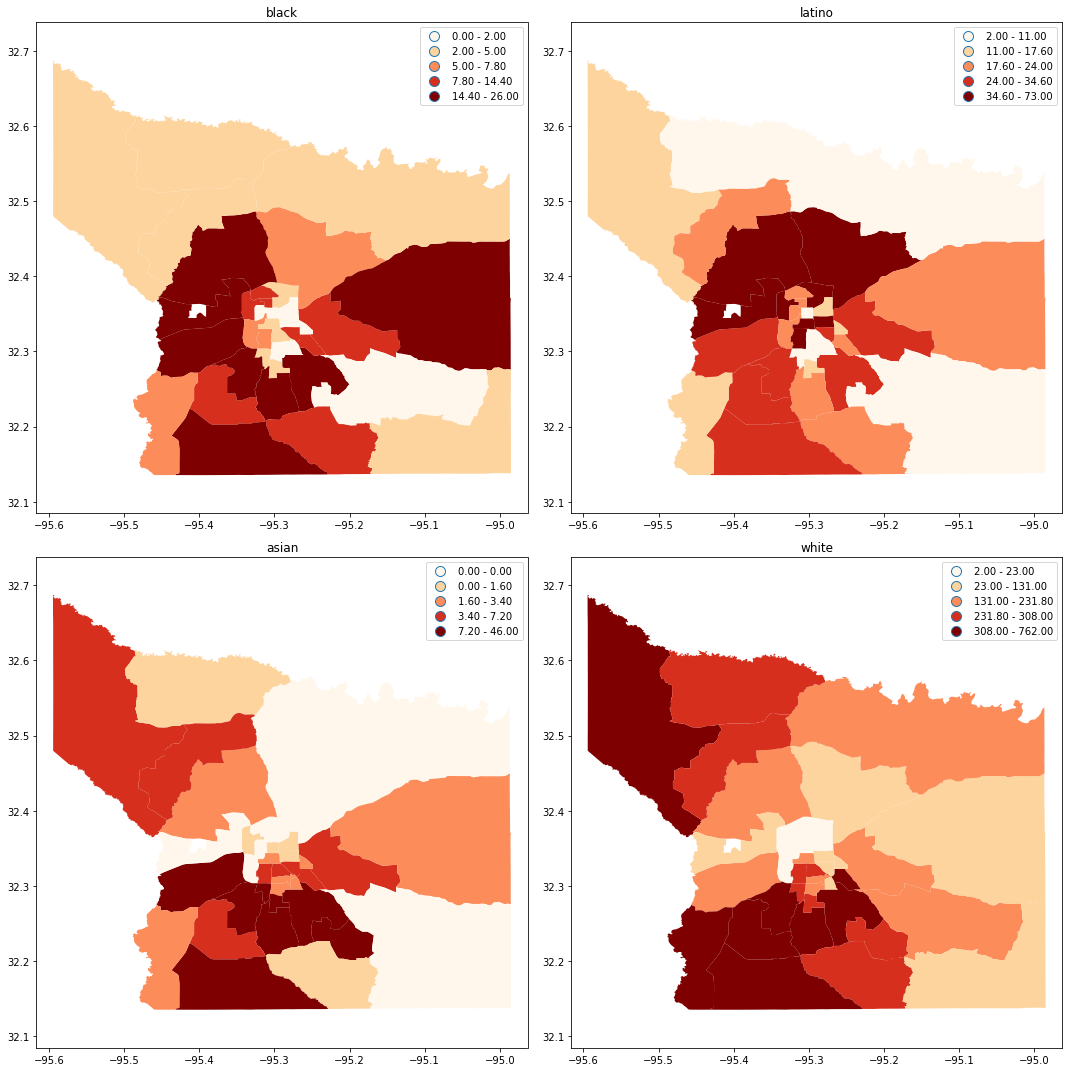

In [278]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts().get('Black', 0)

def latino(group_column):
    return group_column.value_counts().get('Latino', 0)

def asian(group_column):
    return group_column.value_counts().get('Asian', 0)

def white(group_column):
    return group_column.value_counts().get('White', 0)

def other(group_column):
    return group_column.value_counts().get('Other or N/A', 0)

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: What tracts have the highest proportion of loans for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


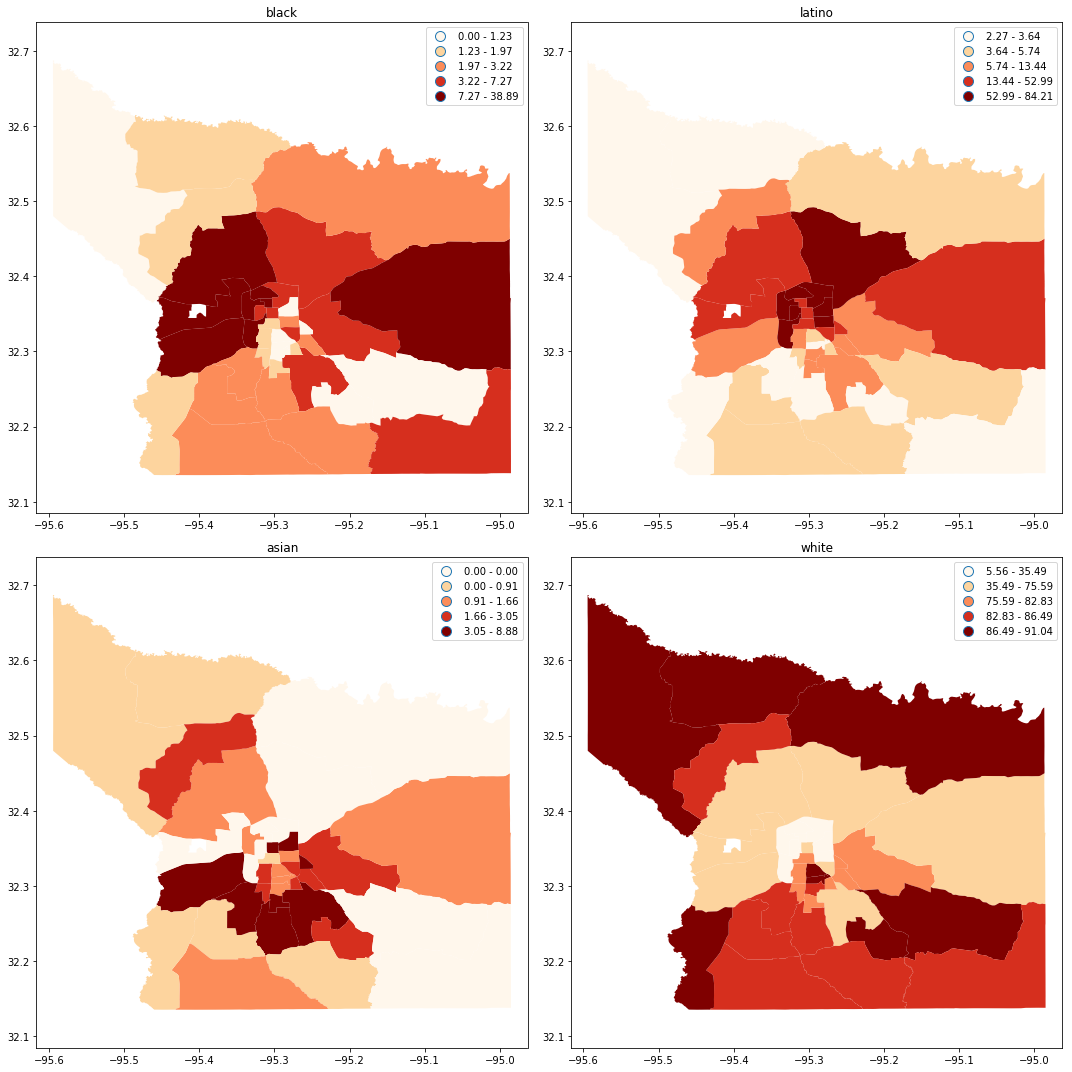

In [280]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': [black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: How are the share of black and Hispanic loans changing over time? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


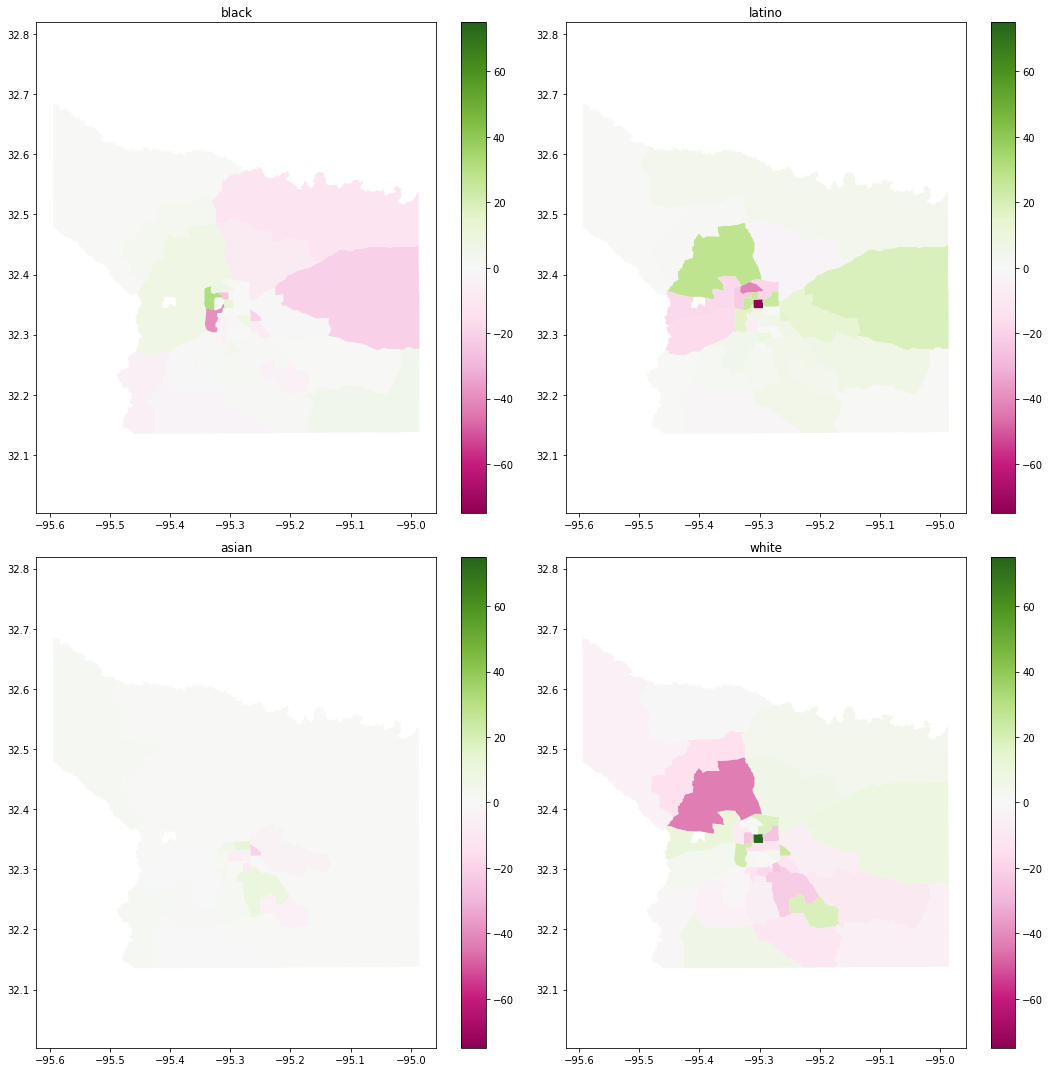

In [283]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

data = data.groupby(['census_tract_number_string', 'as_of_year'], as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

def change(group_column):
    return group_column.iat[-1] - group_column.iat[0]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    ('race_ethnicity', 'black'): change,
    ('race_ethnicity', 'latino'): change,
    ('race_ethnicity', 'asian'): change,
    ('race_ethnicity', 'white'): change
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='PiYG', legend=True, vmin=-75, vmax=75)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Are there particular banks that appear to have higher or lower rates of denial for applicants of color? (2010-2017)

In [292]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['respondent_id', 'race_ethnicity'], as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied]
})

data = data[data[('action_taken_name', 'count')] >= 20]
data = data[data['race_ethnicity'].isin(['Black', 'Latino'])]
data.sort_values(by=[('action_taken_name', 'count')], ascending=False).round(1)

respondent_id race_ethnicity action_taken_name                           
                                             count approved denied pct_denied
51     0000005581         Latino               222      197     25       11.3
119    0000013443         Latino               117      111      6        5.1
190    0000018297         Latino                99       65     34       34.3
824    83-0368926         Latino                89       85      4        4.5
189    0000018297          Black                32       13     19       59.4
244    0000024077         Latino                31       22      9       29.0
752    75-2725402         Latino                27       21      6       22.2
243    0000024077          Black                22       16      6       27.3

# Q: Which banks serve people of color? (2010-2017)

In [297]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('respondent_id').agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = data[
    (data[('race_ethnicity', 'count')] >= 20) & (
        (data[('race_ethnicity', 'black')] > 15) |
        (data[('race_ethnicity', 'latino')] > 15)
    )
]
data.sort_values(by=('race_ethnicity', 'count'), ascending=False).round(1)

race_ethnicity                         
                       count black latino asian white
respondent_id                                        
0000005581               778   1.5   28.5   3.0  64.7
0000013443               538   1.3   21.7   1.3  74.0
83-0368926               109   3.7   81.7   0.0  14.7
0000697633                99   3.0   17.2   2.0  63.6
72-0506617                87  19.5   17.2   0.0  62.1
0002590037                36   0.0   16.7   2.8  66.7
0000021074                27  14.8   25.9   0.0  55.6
0000703155                24  45.8    0.0   0.0  54.2
0000005288                22   4.5   22.7   0.0  68.2
0000018344                21   0.0   23.8   9.5  61.9

# Q: Has the likelihood of being approved as person of color changed over time? (2010-2017)

In [299]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'action_taken_name': ['count', pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data

race_ethnicity as_of_year action_taken_name              \
                                           count  pct_denied   
0             Asian       2010                17   17.647059   
1             Asian       2011                16   25.000000   
2             Asian       2012                19   26.315789   
3             Asian       2013                35   14.285714   
4             Asian       2014                29   24.137931   
5             Asian       2015                43   13.953488   
6             Asian       2016                36   11.111111   
7             Asian       2017                42    7.142857   
8             Black       2010                45   44.444444   
9             Black       2011                21   19.047619   
10            Black       2012                40   57.500000   
11            Black       2013                39   20.512821   
12            Black       2014                47   27.659574   
13            Black       2015                47   36.170213   
14            Black       2016                52   19.230769   
15            Black       2017                63   15.873016   
16           Latino       2010                73   16.438356   
17           Latino       2011                97   18.556701   
18           Latino       2012               108   21.296296   
19           Latino       2013               125   19.200000   
20           Latino       2014               137   23.357664   
21           Latino       2015               142   13.380282   
22           Latino       2016               153   23.529412   
23           Latino       2017               177   17.514124   
24  Native American       2010                 5   40.000000   
25  Native American       2011                 3   33.333333   
26  Native American       2012                14    7.142857   
27  Native American       2013                 8    0.000000   
28  Native American       2014                 6   16.666667   
29  Native American       2015                 2   50.000000   
30  Native American       2016                 5   20.000000   
31  Native American       2017                 7   14.285714   
32  Native Hawaiian       2011                 1    0.000000   
33  Native Hawaiian       2012                 1  100.000000   
34  Native Hawaiian       2013                 3    0.000000   
35  Native Hawaiian       2014                 2    0.000000   
36  Native Hawaiian       2015                 2    0.000000   
37  Native Hawaiian       2016                 2    0.000000   
38  Native Hawaiian       2017                 6    0.000000   
39         Race N/A       2010                49   20.408163   
40         Race N/A       2011                48   12.500000   
41         Race N/A       2012                72   19.444444   
42         Race N/A       2013                65   12.307692   
43         Race N/A       2014                78   14.102564   
44         Race N/A       2015                88   20.454545   
45         Race N/A       2016               108   18.518519   
46         Race N/A       2017               117   11.965812   
47            White       2010               844   11.255924   
48            White       2011               804   10.820896   
49            White       2012               931   12.996778   
50            White       2013              1152   12.065972   
51            White       2014              1215    8.724280   
52            White       2015              1289    9.387122   
53            White       2016              1296    9.413580   
54            White       2017              1361    8.376194   

   applicant_income_000s loan_amount_000s  
                    mean             mean  
0             116.705882       198.705882  
1             102.214286       205.125000  
2             118.000000       189.526316  
3             126.371429       200.742857  
4              97.758621       178.896552  
5             112.627907       230.093023  
6   

# Q: Are there census tracts with exceptionally few or many loans? (2010-2017)

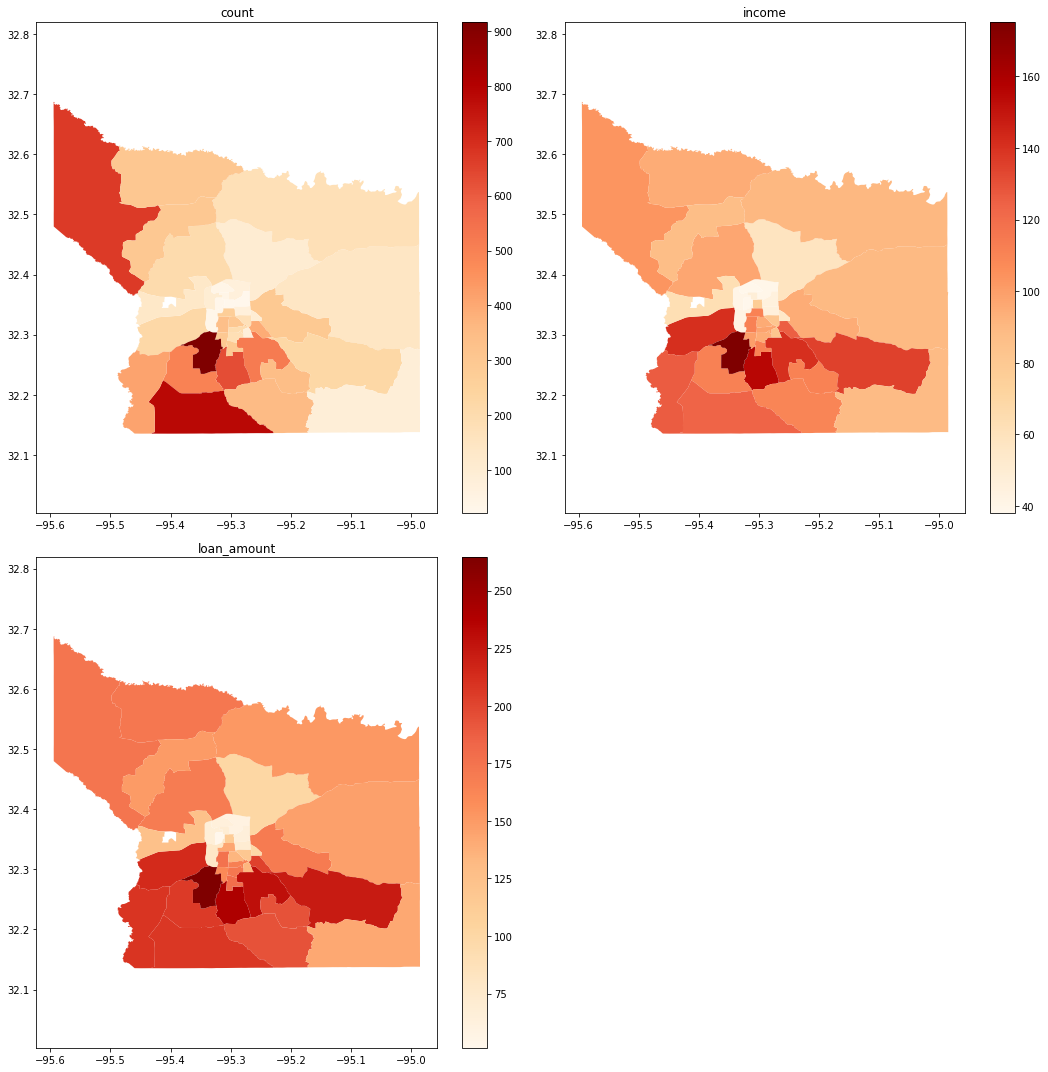

In [300]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'state_name': 'count',
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean'
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

ax = plt.subplot(2, 2, 1)
data.plot(column='state_name', ax=ax, cmap='OrRd', legend=True)
ax.set_title('count')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 2)
data.plot(column='applicant_income_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('income')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 3)
data.plot(column='loan_amount_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('loan_amount')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Is there statistical evidence of bias against applicants of color? (Reveal, 2010-2017)

In [424]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.merge(enriched_census, on='census_tract_number_string')

X = pd.concat([
    pd.Series(data['race_ethnicity'] == 'Black', name='Black', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Latino', name='Latino', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Asian', name='Asian', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native American', name='Native American', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native Hawaiian', name='Native Hawaiian', dtype='int'),
    pd.Series(data['race_ethnicity'].isna(), name='Race N/A', dtype='int'),
    pd.Series(data['applicant_sex_name'] == 'Male', name='Male', dtype='int'),
    pd.Series(data['applicant_sex_name'].isna(), name='Sex N/A', dtype='int'),
    pd.Series(data['co_applicant_sex_name'].isin(['Male', 'Female']), name='Co-applicant', dtype='int'),
    pd.Series(data['co_applicant_sex_name'].isna(), name='Co-applicant N/A', dtype='int'),
    pd.Series(np.log(data['loan_amount_000s']), name='Log of loan'),
    pd.Series(np.log(data['applicant_income_000s']), name='Log of income'),
    pd.Series(data['loan_amount_000s'] / data['applicant_income_000s'], name='Loan-to-income ratio'),
    pd.Series(data['tract_to_msamd_income'], name='Tract-MSA median income ratio'),
    pd.Series(data['percent_black'], name='Percent black in tract'),
    pd.Series(data['percent_latino'], name='Percent Latino in tract'),
    pd.Series(data['percent_asian'], name='Percent Asian in tract'),
    pd.Series(data['percent_native_american'], name='Percent Native American in tract'),
    pd.Series(data['percent_native_hawaiian'], name='Percent Native Hawaiian in tract'),
    pd.Series(data['agency_abbr'] == 'OCC', name='OCC', dtype='int'),
    pd.Series(data['agency_abbr'] == 'FRS', name='FRS', dtype='int'),
    pd.Series(data['agency_abbr'] == 'NCUA', name='NCUA', dtype='int'),
    pd.Series(data['agency_abbr'] == 'HUD', name='HUD', dtype='int'),
    pd.Series(data['agency_abbr'] == 'CFPB', name='CFPB', dtype='int')
], axis=1)

y = pd.Series(data['action_taken_name'] == 'Application denied by financial institution', name='Denied', dtype='int')

logit = sm.Logit(y, X, missing='drop')
result = logit.fit()

result.summary()

# np.exp(result.params)

Optimization terminated successfully.
         Current function value: 0.336451
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Denied   No. Observations:                10256
Model:                          Logit   Df Residuals:                    10232
Method:                           MLE   Df Model:                           23
Date:                Sat, 28 Jul 2018   Pseudo R-squ.:                 0.08657
Time:                        20:43:39   Log-Likelihood:                -3450.6
converged:                       True   LL-Null:                       -3777.7
                                        LLR p-value:                2.073e-123
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Black                                0.9571      0.141      6.800      0.000       0.681       1.233
Latino                               0.1348      0.113      1.190      0.234      -0.087       0.357
Asian                                0.6011      0.199      3.017      0.003       0.211       0.992
Native American                      0.5995      0.427      1.405      0.160      -0.237       1.436
Native Hawaiian                     -0.2894      1.039     -0.278      0.781      -2.327       1.748
Race N/A                             0.2749      0.202      1.360      0.174      -0.121       0.671
Male                                 0.0263      0.076      0.344      0.731      -0.124       0.176
Sex N/A                              0.3728      0.271      1.375      0.169      -0.159       0.904
Co-applicant                         0.0091      0.070      0.129      0.898      -0.129       0.147
Co-applicant N/A                     0.1636      0.253      0.646      0.518      -0.333       0.660
Log of loan                         -0.5964      0.105     -5.654      0.000      -0.803      -0.390
Log of income                        0.1443      0.105      1.378      0.168      -0.061       0.350
Loan-to-income ratio                 0.4056      0.050      8.083      0.000       0.307       0.504
Tract-MSA median income ratio       -0.0033      0.001     -2.400      0.016      -0.006      -0.001
Percent black in tract               0.0081      0.003      2.526      0.012       0.002       0.014
Percent Latino in tract              0.0021      0.003      0.705      0.481      -0.004       0.008
Percent Asian in tract              -0.1351      0.022     -6.177      0.000      -0.178      -0.092
Percent Native American in tract     0.0534      0.070      0.763      0.445      -0.084       0.191
Percent Native Hawaiian in tract     0.1119      0.090      1.247      0.212      -0.064       0.288
OCC                                 -0.2868      0.096     -2.976      0.003      -0.476      -0.098
FRS                                 -0.5666      0.158     -3.590      0.000      -0.876      -0.257
NCUA                                -0.4501      0.127     -3.532      0.000      -0.700      -0.200
HUD                                 -0.5681      0.095     -5.982      0.000      -0.754      -0.382
CFPB                                 0.2677      0.098      2.736      0.006       0.076       0.459
====================================================================================================
"""